<a href="https://colab.research.google.com/github/SambhaviPD/droughtwatch/blob/main/Random_Sweeps_on_Drought_Watch_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install wandb

In [ ]:
!pip install wandb --upgrade

     |████████████████████████████████| 1.8MB 11.2MB/s 
     |████████████████████████████████| 102kB 9.9MB/s 
     |████████████████████████████████| 163kB 35.4MB/s 
     |████████████████████████████████| 133kB 42.7MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=98fe1308231cfacd21c70321c4db894787b0b13fab7822deb8f8400e6006d108
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=a1313cc9bfcd92cb629d0f30a833e0cd6372c1058190f438cb08b298219442e9
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Entire logic of downloading dataset and all process required for train

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import random
import glob
import os
import time
import copy
from pathlib import Path
from itertools import chain
from collections import Counter

# pytorch related imports
import random

from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm.notebook import tqdm

In [ ]:
print("PyTorch version: ", torch.__version__)
print("Torchvision version: ", torchvision.__version__)

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

PyTorch version:  1.8.1+cu101
Torchvision version:  0.9.1+cu101


In [ ]:
# Initial setup per Readme in https://github.com/wandb/droughtwatch

# clone the repository
!git clone https://github.com/wandb/droughtwatch.git

# install wandb
!pip install wandb

%cd droughtwatch

# Download train and validation data
!bash download_data.sh

Cloning into 'droughtwatch'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 113 (delta 0), reused 1 (delta 0), pack-reused 110
Receiving objects: 100% (113/113), 7.52 MiB | 20.21 MiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/droughtwatch
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2050M  100 2050M    0     0  49.7M      0  0:00:41  0:00:41 --:--:-- 62.3M
Archive:  dw_data.zip
   creating: droughtwatch_data/
   creating: droughtwatch_data/val/
  inflating: droughtwatch_data/val/part-r-00090  
  inflating: droughtwatch_data/val/part-r-00061  
  inflating: droughtwatch_data/val/part-r-00052  
  inflating: droughtwatch_data/val/part-r-00043  
  inflating: droughtwatch_data/val/part-r-00040  
  inflating: droughtwatch_data/val/part-r-00042  
  inflating: droughtw

In [ ]:
# Common configuration parameters
train_data_path = 'data/train'
val_data_path = 'data/val'
test_data_path = 'data/test'
data_path = 'data'
folder_path = 'content/droughtwatch'

In [ ]:
label_names = ['0', '1', '2', '3' ]

In [ ]:
# Create folder structure for train
for label in label_names:
  if not os.path.isdir(str(os.path.join(train_data_path, Path(label)))):
    os.makedirs(str(os.path.join(train_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(train_data_path, Path(label)))))

# Create folder structure for val
for label in label_names:
  if not os.path.isdir(str(os.path.join(val_data_path, Path(label)))):
    os.makedirs(str(os.path.join(val_data_path, Path(label))))
  else:
    print('{} already exists!'.format(str(os.path.join(val_data_path, Path(label)))))

In [ ]:
t0 = os.path.join(train_data_path, label_names[0])
t1 = os.path.join(train_data_path, label_names[1])
t2 = os.path.join(train_data_path, label_names[2])
t3 = os.path.join(train_data_path, label_names[3])

In [ ]:
v0 = os.path.join(val_data_path, label_names[0])
v1 = os.path.join(val_data_path, label_names[1])
v2 = os.path.join(val_data_path, label_names[2])
v3 = os.path.join(val_data_path, label_names[3])

In [ ]:
# Data loading functions

# Function that returns files starting with part-r pattern from folder_path
def filelist(folder_path):
  files = Path(folder_path).glob('**/part-r-*')
  print('Number of TFRecordDatasets in {}: {}'.format(folder_path, len(os.listdir(folder_path))))
  return files

def load_data(data_path):
  train = filelist(train_data_path)
  val = filelist(val_data_path)
  return train, val

# Function that parses TFRecordDataset and returns individual records from the Dataset
def parse_file(file):
  filename = tf.data.TFRecordDataset(str(file))
  # TO DO: change make_one_shot_iterator to tf.v2 version
  iterator = tf.compat.v1.data.make_one_shot_iterator(filename)
  
  features = {
    'B1': tf.io.FixedLenFeature([], tf.string),
    'B2': tf.io.FixedLenFeature([], tf.string),
    'B3': tf.io.FixedLenFeature([], tf.string),
    'B4': tf.io.FixedLenFeature([], tf.string),
    'B5': tf.io.FixedLenFeature([], tf.string),
    'B6': tf.io.FixedLenFeature([], tf.string),
    'B7': tf.io.FixedLenFeature([], tf.string),
    'B8': tf.io.FixedLenFeature([], tf.string),
    'B9': tf.io.FixedLenFeature([], tf.string),
    'B10': tf.io.FixedLenFeature([], tf.string),
    'B11': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.int64),
  }

  parsed_files = [tf.io.parse_single_example(data, features) for data in iterator]
  return parsed_files

In [ ]:
# Save TFRecordDataset records to .jpg files in order to proceed with
# Pytorch's data loaders. TO DO: (1) Needto save the images to google drive
# and mount the drive here and proceed rather than executing this
# every time. For the moment proceeding as is.
# (2) Need to see how to manipulate with TFRecordDataset itself. 
# Common configuration parameters
train, val = load_data(data_path)
train_files = []
val_files = []

#%cd 'data/train'
for file in train:
  #print(os.path.basename(file))
  parsed_train_files = parse_file(file)
  train_files.append(parsed_train_files)

for file in val:
  parsed_val_files = parse_file(file)
  val_files.append(parsed_val_files)

print(len(train_files))

Number of TFRecordDatasets in data/train: 405
Number of TFRecordDatasets in data/val: 105
400


Frequency of unique values:
[[    0     1     2     3]
 [51814 12851 13609  8043]]


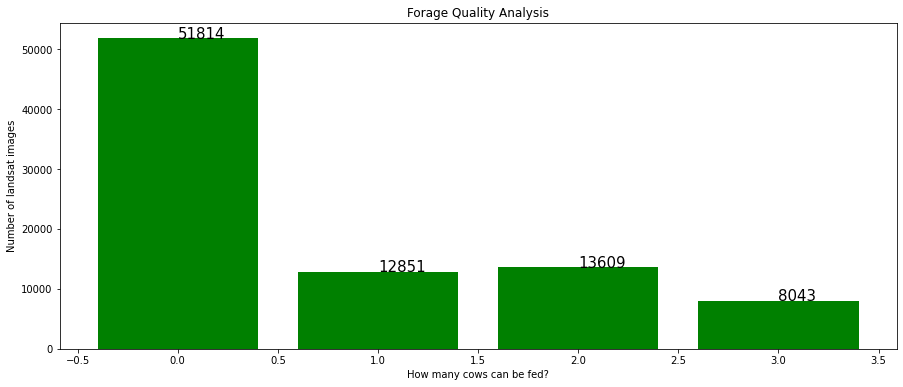

In [ ]:
# Fetch labels from parsed_files
train_labels = np.array([])
for records in train_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if train_labels.size == 0:
    train_labels = np.array([labels])
  else:
    train_labels = np.append(train_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(train_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='green')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

Frequency of unique values:
[[   0    1    2    3]
 [6443 1710 1673  952]]


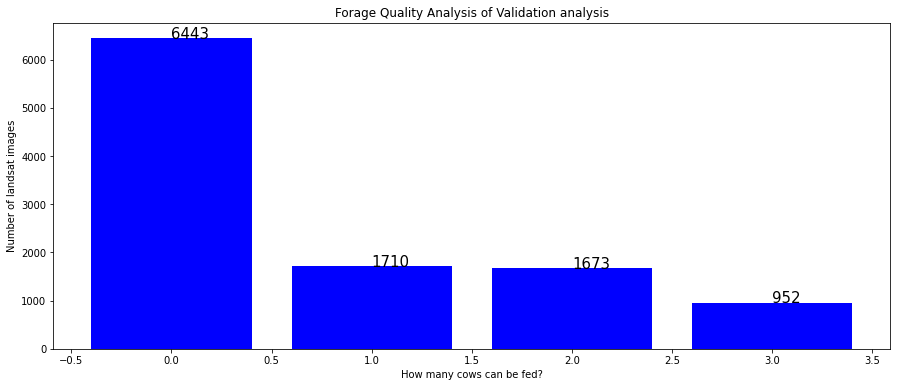

In [ ]:
# Fetch labels from parsed_files - validation data set
val_labels = np.array([])
for records in val_files:
  labels = tf.cast([ record['label'] for record in records], tf.int32).numpy()
  if val_labels.size == 0:
    val_labels = np.array([labels])
  else:
    val_labels = np.append(val_labels, [labels])

# Calculate unique labels and count of each in entire train folder
unique_elements, counts_elements = np.unique(val_labels, return_counts=True)
print("Frequency of unique values:")
print(np.asarray((unique_elements, counts_elements)))

# Plot a bar chart to show data split 
figure = plt.figure(figsize=(15, 6))
plt.title('Forage Quality Analysis of Validation analysis')
plt.xlabel('How many cows can be fed?')
plt.ylabel('Number of landsat images')
plt.bar(unique_elements, counts_elements, color='blue')

# To display count of each label
for index, data in enumerate(counts_elements):
  plt.text(x=index, y=data+1, s=f'{data}', fontdict=dict(fontsize=15))
 
figure.show()

In [ ]:
def get_image_from_example(parsed_example, intensify=True):
  rgbArray = np.zeros((65, 65, 3), 'uint8')
  for i, band in enumerate(['B5', 'B6', 'B7']):
    band_data = np.frombuffer(parsed_example[band].numpy(), dtype=np.uint8)
    band_data = band_data.reshape(65, 65)
    if intensify:
      band_data = band_data/np.max(band_data)*255
    else:
      band_data = band_data*255
    rgbArray[..., i] = band_data

  label = tf.cast(parsed_example['label'], tf.int32).numpy()

  return rgbArray, label

In [ ]:
# One off time
import shutil

# Save files from train as images
cnt = 0
for records in train_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, t0)
    elif label == 1:
      shutil.move(filename, t1)
    elif label == 2:
      shutil.move(filename, t2)
    elif label == 3:
      shutil.move(filename, t3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
# Save files from val as images
cnt = 0
for records in val_files:
  for record in records:
    img, label = get_image_from_example(record)
    filename = 'image-' + str(cnt) + '-label '+ str(label) + '.jpg'
    plt.imsave(filename, img, cmap='gray')
    # Move files to appropriate folders based on their labels
    if label == 0:
      shutil.move(filename, v0)
    elif label == 1:
      shutil.move(filename, v1)
    elif label == 2:
      shutil.move(filename, v2)
    elif label == 3:
      shutil.move(filename, v3)
    else:
      print('Incorrect label')
    cnt += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [ ]:
def make(config):
  # make the model - TO DO: will change model details in a bit
  # model = ConvNet(config.kernels, config.classes).to(device)
  model_ft, input_size = initialize_model("densenet", config.classes, feature_extract=True, 
                                          use_pretrained=True)
  # Make the data
  dataloaders = get_data(input_size, config.batch_size)

  # Make the loss and optimizer
  criterion = nn.CrossEntropyLoss()

  return model_ft, dataloaders, criterion

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained):
  model_ft = None
  input_size = 0

  model_ft = models.densenet121(pretrained=use_pretrained)
  set_parameter_requires_grad(model_ft, feature_extract)
  num_ftrs = model_ft.classifier.in_features
  print('num_ftrs: ', num_ftrs)
  model_ft.classifier = nn.Linear(num_ftrs, num_classes)
  input_size = 224
  
  return model_ft, input_size

In [ ]:
def get_data(input_size, batch_size):
  # Data Augmentation and normalization for Training
  # Just normalization for Validation
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(input_size),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'val': transforms.Compose([
          transforms.Resize(input_size),
          transforms.CenterCrop(input_size),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  print('Initializing Datasets and DataLoaders...')

  # Create training and validation datasets
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_path, x), data_transforms[x]) for x in ['train', 'val']}

  # Create training and validation dataloaders
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                                shuffle=True, num_workers=0) for x in ['train', 'val']}

  print(dataloaders)    
  print(type(dataloaders))                                         

  return dataloaders

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
  if feature_extracting:
    for param in model.parameters():
      param.set_parameter_requires_grad = False

In [ ]:
def create_optimizer(model_ft, optimizer, feature_extract, learning_rate):
  # Gather the parameters to be optimized/updated in this run. If we are
  # finetuning we will be updating all parameters. However, if we are
  # doing feature extract method, we will only update the parameters
  # that we have just initialized, i.e. the parameters with requires_grad
  # is True.
  
  # Send the model to device
  model_ft = model_ft.to(device)
  params_to_update = model_ft.parameters()
  print('Params to learn')
  if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        params_to_update.append(param)
        #print('\t', name)
  else:
    for name, param in model_ft.named_parameters():
      if param.requires_grad == True:
        print('\t', name)

  # Observe that all parameters are optimized
  if optimizer == 'sgd':
    optimizer_ft = optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)
  
  elif optimizer == 'adam':
    optimizer_ft = optim.Adam(params_to_update, lr=learning_rate)

  return optimizer_ft

In [ ]:
# Method to handle training and validation of a given model
def train(config=None):
  # tell wandb to watch what the model gets upto: gradients, weights and more!
  # wandb.watch(model, criterion, log="all", log_freq=10)
  with wandb.init(project="sweep-densenet121", config=None):
    # If called by wandb.agent, as below,
    # this config will be set by Sweep Controller
    config = wandb.config

    # make the model, data and optimization parameters
    model, dataloaders, criterion = make(config)

    # final step for finetuning and feature extracting is to create 
    # an optimizer that only updates the desired parameters
    optimizer = create_optimizer(model, config.optimizer, True, config.learning_rate)

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(config.num_epochs):
      print("Epoch - {} / {}".format(epoch, config.num_epochs - 1))
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ["train", "val"]:
        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        print('phase: {}, device: {}'.format(phase, device))
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase=="train"):
            # get model outputs and calculate loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            # backward and optimize only for training phase
            if phase == "train":
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
        
        # Report metrics to wandb
        if phase == "train":
          wandb.log({"epoch": epoch, "train_loss": epoch_loss, "train_acc": epoch_acc})
        if phase == "val":
          wandb.log({"epoch": epoch, "val_loss":epoch_loss, "val_acc": epoch_acc})

        # deep copy the model
        if phase == "val" and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
        if phase == "val":
          val_acc_history.append(epoch_acc)

        print()

    print("Best Val Accuracy: {:.4f}".format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)

    # Save the model
    torch.save(model.state_dict(best_model_wts), "sweeps-densenet121.pt")

    return model, val_acc_history

# End of methods related to train

#Configure the sweep, to start with choose random. Other options are grid and bayesian search.

In [ ]:
sweep_config = {
    'method' : 'random'
}

#Define the metric

In [ ]:
metric = {
    'val_metrics' : {
        'loss' : 'val_loss',
        'accuracy' : 'val_acc',
    },
    'train_metrics' : {
        'loss' : 'train_loss',
        'accuracy' : 'train_acc',
    },
}

sweep_config['metric'] = metric

#Define parameters

In [ ]:
parameters_dict = {
    'optimizer' : {
        'values' : ['adam', 'sgd']
    },
    'fc_layer_size' : {
        'values' : [128, 256, 512]
    },
    'dropout' : {
        'values' : [0.3, 0.4, 0.5]
    },
}

sweep_config['parameters'] = parameters_dict

In [ ]:
parameters_dict.update({
    'num_epochs' : {
        'value' : 5
    }
})

In [ ]:
import math

parameters_dict.update({
    'learning_rate' : {
        # a flat distribution between 0 and 0.1
        'distribution' : 'uniform',
        'min' : 0.0003,
        'max' : 0.0005
    },
    'batch_size' : {
        # integers between 32 and 256
        # with evenly distributed logarithms
        'distribution' : 'q_log_uniform',
        'q' : 1,
        'min' : math.log(32),
        'max' : math.log(128),
        #'values' : [32, 64, 128]
    },
    'classes' : {
        'value' : 5,
    },
})

In [ ]:
sweep_config

{'method': 'random',
 'metric': {'train_metrics': {'accuracy': 'train_acc', 'loss': 'train_loss'},
  'val_metrics': {'accuracy': 'val_acc', 'loss': 'val_loss'}},
 'parameters': {'batch_size': {'distribution': 'q_log_uniform',
   'max': 4.852030263919617,
   'min': 3.4657359027997265,
   'q': 1},
  'classes': {'value': 5},
  'dropout': {'values': [0.3, 0.4, 0.5]},
  'fc_layer_size': {'values': [128, 256, 512]},
  'learning_rate': {'distribution': 'uniform', 'max': 0.0005, 'min': 0.0003},
  'num_epochs': {'value': 5},
  'optimizer': {'values': ['adam', 'sgd']}}}

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-densenet121")

Create sweep with ID: w06m6wsq
Sweep URL: https://wandb.ai/prettycold/sweeps-densenet121/sweeps/w06m6wsq


In [ ]:
wandb.agent(sweep_id, train, count=20)

wandb: Agent Starting Run: le0nqdtv with config:
wandb: 	batch_size: 35
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0003811701030074672
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: Currently logged in as: prettycold (use `wandb login --relogin` to force relogin)
wandb: WARNING Ignored wandb.init() arg project when running a sweep


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1682f75410>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1682f75e90>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9802 Acc: 0.6196

phase: val, device: cuda:0
val Loss: 0.9369 Acc: 0.6392

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9038 Acc: 0.6486

phase: val, device: cuda:0
val Loss: 0.8120 Acc: 0.6874

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8586 Acc: 0.6684

phase: val, device: cuda:0
val Loss: 0.7846 Acc: 0.7021

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8246 Acc: 0.6828

phase: val, device: cuda:0
val Loss: 0.7561 Acc: 0.7121

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8020 Acc: 0.6903

phase: val, device: cuda:0
val Loss: 0.7445 Acc: 0.7191

Best Val Accuracy: 0.7191


epoch,4
train_loss,0.80201
train_acc,0.69027
_runtime,3819
_timestamp,1620710719
_step,9
val_loss,0.7445
val_acc,0.71906


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▄▆▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▃▂▁▁
val_acc,▁▅▇▇█


wandb: Agent Starting Run: kueadv8a with config:
wandb: 	batch_size: 61
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.00047436826604708375
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f168380a5d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f168382ad90>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9595 Acc: 0.6250

phase: val, device: cuda:0
val Loss: 0.9047 Acc: 0.6433

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8959 Acc: 0.6523

phase: val, device: cuda:0
val Loss: 0.8368 Acc: 0.6797

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8590 Acc: 0.6686

phase: val, device: cuda:0
val Loss: 0.8141 Acc: 0.6874

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8284 Acc: 0.6790

phase: val, device: cuda:0
val Loss: 0.7936 Acc: 0.6967

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8164 Acc: 0.6862

phase: val, device: cuda:0
val Loss: 0.7843 Acc: 0.7010

Best Val Accuracy: 0.7010


epoch,4
train_loss,0.81643
train_acc,0.6862
_runtime,3756
_timestamp,1620714481
_step,9
val_loss,0.78431
val_acc,0.70096


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▄▆▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▄▃▂▁
val_acc,▁▅▆▇█


wandb: Agent Starting Run: ieiikz0h with config:
wandb: 	batch_size: 42
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004037282149854742
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1682f57450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1682f57510>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9800 Acc: 0.6165

phase: val, device: cuda:0
val Loss: 0.9088 Acc: 0.6454

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9038 Acc: 0.6483

phase: val, device: cuda:0
val Loss: 0.8342 Acc: 0.6808

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8613 Acc: 0.6680

phase: val, device: cuda:0
val Loss: 0.7891 Acc: 0.7017

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8275 Acc: 0.6822

phase: val, device: cuda:0
val Loss: 0.7653 Acc: 0.7062

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8035 Acc: 0.6928

phase: val, device: cuda:0
val Loss: 0.7400 Acc: 0.7131

Best Val Accuracy: 0.7131


epoch,4
train_loss,0.80354
train_acc,0.69283
_runtime,3789
_timestamp,1620718276
_step,9
val_loss,0.74003
val_acc,0.71312


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▄▆▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▂▁
val_acc,▁▅▇▇█


wandb: Agent Starting Run: zrqn7pll with config:
wandb: 	batch_size: 40
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.00048196654728074623
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1682f57450>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1681297190>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9960 Acc: 0.6121

phase: val, device: cuda:0
val Loss: 1.0459 Acc: 0.6252

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9445 Acc: 0.6298

phase: val, device: cuda:0
val Loss: 0.9530 Acc: 0.6315

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9106 Acc: 0.6441

phase: val, device: cuda:0
val Loss: 0.8592 Acc: 0.6681

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8791 Acc: 0.6588

phase: val, device: cuda:0
val Loss: 0.8207 Acc: 0.6857

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8524 Acc: 0.6708

phase: val, device: cuda:0
val Loss: 0.8044 Acc: 0.6829

Best Val Accuracy: 0.6857


epoch,4
train_loss,0.85239
train_acc,0.67084
_runtime,4059
_timestamp,1620722341
_step,9
val_loss,0.80436
val_acc,0.68287


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▄▂▁
train_acc,▁▃▅▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▁▁
val_acc,▁▂▆██


wandb: Agent Starting Run: o6731tde with config:
wandb: 	batch_size: 67
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004216626288121789
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f178e40b050>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1681f97090>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9902 Acc: 0.6144

phase: val, device: cuda:0
val Loss: 0.9295 Acc: 0.6308

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9201 Acc: 0.6403

phase: val, device: cuda:0
val Loss: 0.8694 Acc: 0.6587

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8769 Acc: 0.6614

phase: val, device: cuda:0
val Loss: 0.8193 Acc: 0.6813

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8437 Acc: 0.6745

phase: val, device: cuda:0
val Loss: 0.7836 Acc: 0.6999

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8175 Acc: 0.6875

phase: val, device: cuda:0
val Loss: 0.7621 Acc: 0.7078

Best Val Accuracy: 0.7078


epoch,4
train_loss,0.81755
train_acc,0.68747
_runtime,3629
_timestamp,1620725976
_step,9
val_loss,0.76209
val_acc,0.70783


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▃▆▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▂▁
val_acc,▁▄▆▇█


wandb: Agent Starting Run: c7jc6gt4 with config:
wandb: 	batch_size: 65
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.00030761691157265143
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f168211d8d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1681df6d50>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9961 Acc: 0.6139

phase: val, device: cuda:0
val Loss: 0.9379 Acc: 0.6268

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9349 Acc: 0.6337

phase: val, device: cuda:0
val Loss: 0.8871 Acc: 0.6497

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8947 Acc: 0.6534

phase: val, device: cuda:0
val Loss: 0.8406 Acc: 0.6793

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8656 Acc: 0.6667

phase: val, device: cuda:0
val Loss: 0.8079 Acc: 0.6898

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8403 Acc: 0.6776

phase: val, device: cuda:0
val Loss: 0.7867 Acc: 0.7011

Best Val Accuracy: 0.7011


epoch,4
train_loss,0.84028
train_acc,0.67758
_runtime,3630
_timestamp,1620729613
_step,9
val_loss,0.78668
val_acc,0.70106


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▃▅▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▆▃▂▁
val_acc,▁▃▆▇█


wandb: Agent Starting Run: j5c3roka with config:
wandb: 	batch_size: 71
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004350698577064618
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f168132ad10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f168132ad90>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9899 Acc: 0.6140

phase: val, device: cuda:0
val Loss: 0.9443 Acc: 0.6235

Epoch - 1 / 4
----------
phase: train, device: cuda:0
train Loss: 0.9199 Acc: 0.6408

phase: val, device: cuda:0
val Loss: 0.8651 Acc: 0.6585

Epoch - 2 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8789 Acc: 0.6587

phase: val, device: cuda:0
val Loss: 0.8176 Acc: 0.6852

Epoch - 3 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8443 Acc: 0.6763

phase: val, device: cuda:0
val Loss: 0.7866 Acc: 0.6927

Epoch - 4 / 4
----------
phase: train, device: cuda:0
train Loss: 0.8181 Acc: 0.6850

phase: val, device: cuda:0
val Loss: 0.7592 Acc: 0.7098

Best Val Accuracy: 0.7098


epoch,4
train_loss,0.81809
train_acc,0.685
_runtime,3606
_timestamp,1620733225
_step,9
val_loss,0.75922
val_acc,0.70978


epoch,▁▁▃▃▅▅▆▆██
train_loss,█▅▃▂▁
train_acc,▁▄▅▇█
_runtime,▁▁▃▃▄▅▆▆██
_timestamp,▁▁▃▃▄▅▆▆██
_step,▁▂▃▃▄▅▆▆▇█
val_loss,█▅▃▂▁
val_acc,▁▄▆▇█


wandb: Agent Starting Run: 9q4aa5ep with config:
wandb: 	batch_size: 127
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0003794995356912628
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f178e40b890>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1682119e10>}
<class 'dict'>
Params to learn
Epoch - 0 / 4
----------
phase: train, device: cuda:0


Run 9q4aa5ep errored: RuntimeError('CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 27.75 MiB free; 14.87 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9q4aa5ep errored: RuntimeError('CUDA out of memory. Tried to allocate 14.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 27.75 MiB free; 14.87 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: j1q6qxar with config:
wandb: 	batch_size: 71
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.0004964068805973615
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f16811c0d10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f16811c0e50>}
<class 'dict'>


Run j1q6qxar errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run j1q6qxar errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 55snq93r with config:
wandb: 	batch_size: 62
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.00039302837255596814
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f169b674210>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f169b674050>}
<class 'dict'>


Run 55snq93r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run 55snq93r errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 7q8nr66h with config:
wandb: 	batch_size: 99
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004489242249111563
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f16857d2f90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f16857d62d0>}
<class 'dict'>


Run 7q8nr66h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run 7q8nr66h errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: a35mf7jp with config:
wandb: 	batch_size: 103
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.00042605873335707986
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f1685812850>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f16858124d0>}
<class 'dict'>


Run a35mf7jp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run a35mf7jp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: x2j9892t with config:
wandb: 	batch_size: 111
wandb: 	classes: 5
wandb: 	dropout: 0.3
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.00033301637560707094
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f15a69b2a10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f1683627710>}
<class 'dict'>


Run x2j9892t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run x2j9892t errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nfivpnwz with config:
wandb: 	batch_size: 76
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0003146910047176632
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f16848eeb50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f16848eeb10>}
<class 'dict'>


Run nfivpnwz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run nfivpnwz errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: pr3fy3c5 with config:
wandb: 	batch_size: 118
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004165085231931042
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f158c48cf50>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f158c48ccd0>}
<class 'dict'>


Run pr3fy3c5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run pr3fy3c5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 1hit42c5 with config:
wandb: 	batch_size: 61
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 512
wandb: 	learning_rate: 0.00036387190019287064
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f16851538d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f15a9e79510>}
<class 'dict'>


Run 1hit42c5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run 1hit42c5 errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: 9rajohnp with config:
wandb: 	batch_size: 41
wandb: 	classes: 5
wandb: 	dropout: 0.3
wandb: 	fc_layer_size: 128
wandb: 	learning_rate: 0.0004791868395196813
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f15a7a4ad90>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f15a7a4aa50>}
<class 'dict'>


Run 9rajohnp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run 9rajohnp errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: wyv2zobq with config:
wandb: 	batch_size: 61
wandb: 	classes: 5
wandb: 	dropout: 0.3
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.000403321130223168
wandb: 	num_epochs: 5
wandb: 	optimizer: sgd
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f15a67f79d0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f15a67f7190>}
<class 'dict'>


Run wyv2zobq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run wyv2zobq errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: q6nq0dox with config:
wandb: 	batch_size: 60
wandb: 	classes: 5
wandb: 	dropout: 0.4
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.00037710706007120756
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f158d5b9ed0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f158d5b9b50>}
<class 'dict'>


Run q6nq0dox errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run q6nq0dox errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: Agent Starting Run: vrcccq3j with config:
wandb: 	batch_size: 60
wandb: 	classes: 5
wandb: 	dropout: 0.5
wandb: 	fc_layer_size: 256
wandb: 	learning_rate: 0.0004047564174373442
wandb: 	num_epochs: 5
wandb: 	optimizer: adam
wandb: WARNING Ignored wandb.init() arg project when running a sweep


num_ftrs:  1024
Initializing Datasets and DataLoaders...
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f152de9af10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f158d527f90>}
<class 'dict'>


Run vrcccq3j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
wandb: ERROR Run vrcccq3j errored: RuntimeError('CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 15.90 GiB total capacity; 14.63 GiB already allocated; 21.75 MiB free; 14.88 GiB reserved in total by PyTorch)')
